In [1]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import scanpy as sc
import scvi
import seaborn as sns
from scvi.external import MRVI

import matplotlib as mpl
mpl.rcParams.update({'svg.fonttype': 'none'})

### Load data

In [2]:
pert_type = "crispri"

In [3]:
scvi.settings.seed = 0  # optional: ensures reproducibility
print("Last run with scvi-tools version:", scvi.__version__)
save_dir = f"/home/user/Documents/Kinase_project/figures/mrvi/{pert_type}_saved_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
output_dir = os.path.join(f"/home/user/Documents/Kinase_project/figures/mrvi/{pert_type}_saved_outputs")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
figure_dir = os.path.join(f"/home/user/Documents/Kinase_project/figures/mrvi/{pert_type}_figures")
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
data_dir = f'/home/user/Documents/Kinase_project/{pert_type}_final/'
adata_path = os.path.join(data_dir, f"filtered_gbm_{pert_type}_crop.h5ad")

Seed set to 0


Last run with scvi-tools version: 1.3.2


In [4]:
adata = sc.read(adata_path)
adata

AnnData object with n_obs × n_vars = 30614 × 1669
    obs: 'P7', 'P5', 'sample', 'n.umi', 'log10.umi', 'percent_mito', 'cell_ID', 'RT', 'Lig', 'new_cell', 'oligo', 'total_reads.x', 'total_hash_umis_per_cell_ID', 'top_to_second_best_ratio', 'treatment', 'sgRNA', 'total_reads.y', 'sgRNA_proportion', 'total_sgrna_read_per_cell', 'rank', 'top_to_second', 'second_to_third', 'third_to_next', 'top_proportion', 'second_proportion', 'third_proportion', 'top_sg', 'second_sg', 'third_sg', 'gene', 'second_sg_gene', 'third_sg_gene', 'cell', 'RT_lig', 'num_genes_expressed', 'Size_Factor', 'gene_id', 'replicate', 'g1s_score', 'g2m_score', 'proliferation_index', 'dose', 'UMAP1', 'UMAP2', 'PCA_Cluster', 'batch'
    var: 'features'

In [5]:
dosage_colors = {
    "0": "#023047",
    "0.25": "#219EBC",
    "0.5": "#FFD166",
    "1": "#FF7F11",
}

In [6]:
adata = adata[(adata.obs['total_hash_umis_per_cell_ID']>2) & (adata.obs['top_to_second_best_ratio']>2)].copy()


In [7]:
adata

AnnData object with n_obs × n_vars = 23139 × 1669
    obs: 'P7', 'P5', 'sample', 'n.umi', 'log10.umi', 'percent_mito', 'cell_ID', 'RT', 'Lig', 'new_cell', 'oligo', 'total_reads.x', 'total_hash_umis_per_cell_ID', 'top_to_second_best_ratio', 'treatment', 'sgRNA', 'total_reads.y', 'sgRNA_proportion', 'total_sgrna_read_per_cell', 'rank', 'top_to_second', 'second_to_third', 'third_to_next', 'top_proportion', 'second_proportion', 'third_proportion', 'top_sg', 'second_sg', 'third_sg', 'gene', 'second_sg_gene', 'third_sg_gene', 'cell', 'RT_lig', 'num_genes_expressed', 'Size_Factor', 'gene_id', 'replicate', 'g1s_score', 'g2m_score', 'proliferation_index', 'dose', 'UMAP1', 'UMAP2', 'PCA_Cluster', 'batch'
    var: 'features'

In [8]:
mapping = {1.00: '1to1', 0.50: '1to0.5', 0.25: '1to0.25', 0.00: 'Untreated'}
adata.obs['treatment'] = adata.obs['dose'].replace(mapping)
    
    

In [9]:

mapping = {1.00: "1", 0.50: "0.5", 0.25: "0.25", 0.00: "0"}
adata.obs['dosage'] = adata.obs['dose'].replace(mapping)

In [10]:

adata.obs['dosage'] = pd.Categorical(adata.obs['dosage'], categories=['0', '0.25', '0.5', '1'], ordered=True)

In [11]:
adata.obs['gene_id']

01D_A01_RT_BC_100_Lig_BC_122-0      NTC
01D_A01_RT_BC_103_Lig_BC_64-0       NTC
01D_C01_RT_BC_146_Lig_BC_29-0       NTC
01D_D01_RT_BC_117_Lig_BC_39-0       NTC
01D_D01_RT_BC_150_Lig_BC_120-0      NTC
                                  ...  
12D_H12_RT_BC_98_Lig_BC_44-1      DAPK2
12D_H12_RT_BC_98_Lig_BC_7-1       STK35
12D_H12_RT_BC_98_Lig_BC_87-1      CDKL1
12D_H12_RT_BC_99_Lig_BC_126-1     CHEK2
12D_H12_RT_BC_99_Lig_BC_86-1       JAK1
Name: gene_id, Length: 23139, dtype: category
Categories (141, object): ['ABL1', 'ACVR2B', 'ADCK3', 'ADRBK2', ..., 'TYK2', 'WEE1', 'WNK2', 'WNK3']

In [12]:
adata.obs['cell_type'] = "T-cells"

In [13]:
adata.obs['replicate'] = adata.obs['oligo'].str.extract(r'(R[12])')
adata.obs['replicate']

01D_A01_RT_BC_100_Lig_BC_122-0    R2
01D_A01_RT_BC_103_Lig_BC_64-0     R1
01D_C01_RT_BC_146_Lig_BC_29-0     R1
01D_D01_RT_BC_117_Lig_BC_39-0     R2
01D_D01_RT_BC_150_Lig_BC_120-0    R1
                                  ..
12D_H12_RT_BC_98_Lig_BC_44-1      R1
12D_H12_RT_BC_98_Lig_BC_7-1       R2
12D_H12_RT_BC_98_Lig_BC_87-1      R2
12D_H12_RT_BC_99_Lig_BC_126-1     R1
12D_H12_RT_BC_99_Lig_BC_86-1      R2
Name: replicate, Length: 23139, dtype: object

In [14]:
adata.obs['treatment_geneid'] = adata.obs['treatment'].astype(str)+'_'+adata.obs['gene_id'].astype(str)

In [15]:
adata.obs['treatment_geneid'] 

01D_A01_RT_BC_100_Lig_BC_122-0       1to0.5_NTC
01D_A01_RT_BC_103_Lig_BC_64-0     Untreated_NTC
01D_C01_RT_BC_146_Lig_BC_29-0        1to0.5_NTC
01D_D01_RT_BC_117_Lig_BC_39-0          1to1_NTC
01D_D01_RT_BC_150_Lig_BC_120-0      1to0.25_NTC
                                      ...      
12D_H12_RT_BC_98_Lig_BC_44-1      1to0.25_DAPK2
12D_H12_RT_BC_98_Lig_BC_7-1        1to0.5_STK35
12D_H12_RT_BC_98_Lig_BC_87-1         1to1_CDKL1
12D_H12_RT_BC_99_Lig_BC_126-1        1to1_CHEK2
12D_H12_RT_BC_99_Lig_BC_86-1       1to0.25_JAK1
Name: treatment_geneid, Length: 23139, dtype: object

### Train model

In [16]:
save_path = os.path.join(save_dir, f"{pert_type}_treatment_gene_id_mrvi")
if not os.path.exists(save_path):
    sample_key = 'treatment_geneid'  # target covariate
    batch_key="replicate"  # nuisance variable identifier
    MRVI.setup_anndata(adata, sample_key=sample_key, batch_key = batch_key)

    model = MRVI(adata)
    model.train(max_epochs=400)
    model.save(dir_path=save_path, save_anndata=True)
else:
    model = MRVI.load(save_path, adata=adata)

INFO     File                                                                                                      
         /home/user/Documents/Kinase_project/figures/mrvi/crispri_saved_models/crispri_treatment_gene_id_mrvi/model
         .pt already downloaded                                                                                    


INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


/home/user/anaconda3/envs/scvi-env/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 290 in adata.obs['_scvi_sample'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/home/user/anaconda3/envs/scvi-env/lib/python3.12/site-packages/scvi/module/base/_base_module.py:723: UserWarning: Running mrVI with Jax version larger 0.4.35 can cause performance issues
  model.train(max_steps=1)
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/user/anaconda3/envs/scvi-env/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/user/anaconda3/envs/scvi-env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the

Epoch 1/346:   0%|          | 0/346 [00:00<?, ?it/s]

/home/user/anaconda3/envs/scvi-env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:369: You have overridden `transfer_batch_to_device` in `LightningModule` but have passed in a `LightningDataModule`. It will use the implementation from `LightningModule` instance.


Epoch 1/346:   0%|          | 1/346 [00:22<2:07:58, 22.26s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.85e+3]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/346:   0%|          | 1/346 [00:22<2:08:00, 22.26s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.85e+3]


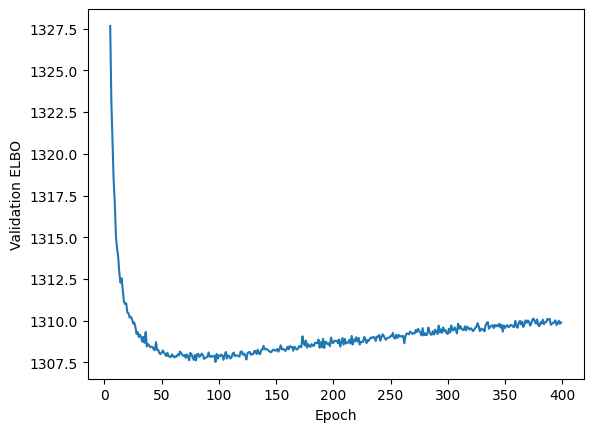

In [17]:
plt.plot(model.history["elbo_validation"].iloc[5:])
plt.xlabel("Epoch")
plt.ylabel("Validation ELBO")
plt.show()

In [18]:
adata.obs.columns

Index(['P7', 'P5', 'sample', 'n.umi', 'log10.umi', 'percent_mito', 'cell_ID',
       'RT', 'Lig', 'new_cell', 'oligo', 'total_reads.x',
       'total_hash_umis_per_cell_ID', 'top_to_second_best_ratio', 'treatment',
       'sgRNA', 'total_reads.y', 'sgRNA_proportion',
       'total_sgrna_read_per_cell', 'rank', 'top_to_second', 'second_to_third',
       'third_to_next', 'top_proportion', 'second_proportion',
       'third_proportion', 'top_sg', 'second_sg', 'third_sg', 'gene',
       'second_sg_gene', 'third_sg_gene', 'cell', 'RT_lig',
       'num_genes_expressed', 'Size_Factor', 'gene_id', 'replicate',
       'g1s_score', 'g2m_score', 'proliferation_index', 'dose', 'UMAP1',
       'UMAP2', 'PCA_Cluster', 'batch', 'dosage', 'cell_type',
       'treatment_geneid', '_indices', '_scvi_sample', '_scvi_batch',
       '_scvi_labels'],
      dtype='object')

In [19]:
model

Training status: Trained

### Plot figures

In [20]:
u = model.get_latent_representation()
adata.obsm["mrvi_u"] = u
sc.pp.neighbors(adata, use_rep='mrvi_u')
sc.tl.umap(adata, random_state=0)
fig = sc.pl.umap(adata, color=['treatment'], show=False, return_fig=True)
plt.savefig(os.path.join(figure_dir, "mrvi_u_embedding_treatment.pdf"), bbox_inches='tight')
plt.close(fig)


100%|██████████| 181/181 [00:01<00:00, 112.35it/s]


In [21]:
# Fig 2C
with plt.rc_context({"figure.figsize": (4,4)}):
    sc.pl.umap(adata, color=['dosage'], palette=dosage_colors, show=False )
    plt.savefig(os.path.join(figure_dir, "mrvi_u_embedding_dosage.png"), dpi=300, bbox_inches='tight')
    plt.close()  # Close current figure, not the return value

with plt.rc_context({"figure.figsize": (4,4)}):
    sc.pl.umap(adata, color=['dosage'], palette=dosage_colors, show=False)
    plt.savefig(os.path.join(figure_dir, "mrvi_u_embedding_dosage.svg"), dpi=300, bbox_inches='tight')
    plt.close()  # Close current figure
    
with plt.rc_context({"figure.figsize": (4,4)}):
    sc.pl.umap(adata, color=['dosage'], palette=dosage_colors, show=False)
    plt.savefig(os.path.join(figure_dir, "mrvi_u_embedding_dosage.pdf"), dpi=300, bbox_inches='tight')
    plt.close()  # Close current figure

In [22]:

fig = sc.pl.umap(adata, color=['gene_id'], show=False, return_fig=True)
plt.savefig(os.path.join(figure_dir, "mrvi_u_embedding_gene_id.pdf"), bbox_inches='tight')
plt.close(fig)

fig = sc.pl.umap(adata, color=['treatment_geneid'], show=False, return_fig=True)
plt.savefig(os.path.join(figure_dir, "mrvi_u_embedding_treatment_gene_id.pdf"), bbox_inches='tight')
plt.close(fig)

In [23]:
z = model.get_latent_representation(give_z=True)
adata.obsm["mrvi_z"] = z
sc.pp.neighbors(adata, use_rep='mrvi_z')
sc.tl.umap(adata, random_state=0)
fig = sc.pl.umap(adata, color=['treatment'], show=False, return_fig=True)
plt.savefig(os.path.join(figure_dir, "mrvi_z_embedding_treatment.pdf"), bbox_inches='tight')
plt.close(fig)
fig = sc.pl.umap(adata, color=['gene_id'], show=False, return_fig=True)
plt.savefig(os.path.join(figure_dir, "mrvi_z_embedding_gene_id.pdf"), bbox_inches='tight')
plt.close(fig)


100%|██████████| 181/181 [00:01<00:00, 115.77it/s]


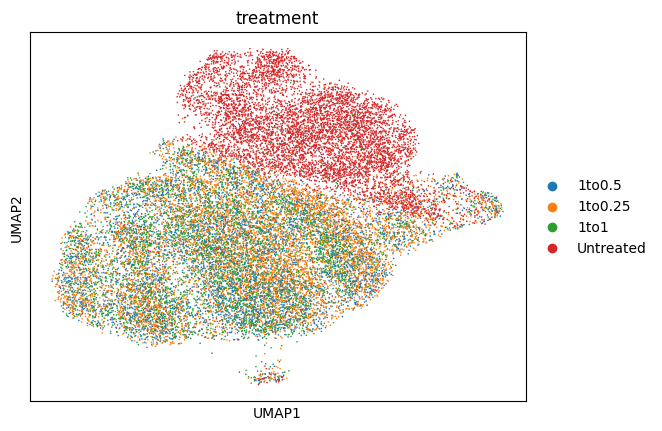

In [24]:
sc.pl.umap(adata, color=['treatment'])

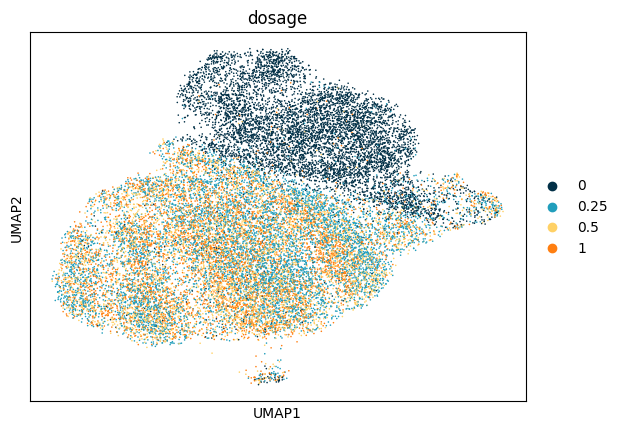

In [25]:
sc.pl.umap(adata, color=['dosage'], palette=dosage_colors)

In [26]:
# Fig 2C
with plt.rc_context({"figure.figsize": (4,4)}):
    sc.pl.umap(adata, color=['dosage'], palette=dosage_colors, show=False )
    plt.savefig(os.path.join(figure_dir, "mrvi_z_embedding_dosage.png"), dpi=300, bbox_inches='tight')
    plt.close()  # Close current figure, not the return value

with plt.rc_context({"figure.figsize": (4,4)}):
    sc.pl.umap(adata, color=['dosage'], palette=dosage_colors, show=False)
    plt.savefig(os.path.join(figure_dir, "mrvi_z_embedding_dosage.svg"), dpi=300, bbox_inches='tight')
    plt.close()  # Close current figure
    
with plt.rc_context({"figure.figsize": (4,4)}):
    sc.pl.umap(adata, color=['dosage'], palette=dosage_colors, show=False)
    plt.savefig(os.path.join(figure_dir, "mrvi_z_embedding_dosage.pdf"), dpi=300, bbox_inches='tight')
    plt.close()  # Close current figure

In [27]:
dists_path = os.path.join(output_dir, f"{pert_type}_mrvi_treatment_geneid_dists.nc")
if not os.path.exists(dists_path):
    dists = model.get_local_sample_distances(
        keep_cell=False, groupby = 'treatment', batch_size=32
    )
    dists.to_netcdf(dists_path)
else:
    dists = xr.open_dataset(dists_path)

In [28]:
from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering
from scipy.spatial.distance import squareform

def get_dendrogram(dists):
    ds = squareform(dists)
    Z = linkage(ds, method="ward")
    Z = optimal_leaf_ordering(Z, ds)
    return Z

In [ ]:
from scipy.cluster.hierarchy import fcluster
import scipy.stats as stats
import pandas as pd
import numpy as np
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

distance_threshold = 0.4  # Adjust this threshold based on dendrogram inspection
results_df_all = pd.DataFrame()
for treatment in adata.obs["treatment"].unique():
    print(treatment)
    d1 = dists.loc[{"treatment_name": treatment}].treatment
    Z = get_dendrogram(d1)
    sns.clustermap(
        d1.to_pandas(),
        row_linkage=Z,
        col_linkage=Z,
        xticklabels=False,
        yticklabels=True,
        figsize=(50, 50)
    )
    plt.savefig(os.path.join(figure_dir, f"mrvi_{treatment}_dendrogram.pdf"), bbox_inches='tight', dpi = 300)
    plt.savefig(os.path.join(figure_dir, f"mrvi_{treatment}_dendrogram.png"), bbox_inches='tight', dpi = 300)
    plt.savefig(os.path.join(figure_dir, f"mrvi_{treatment}_dendrogram.svg"), bbox_inches='tight', dpi = 300)
    plt.close()


1to0.5
Untreated
1to1
1to0.25


In [30]:
dists

<xarray.Dataset> Size: 5MB
Dimensions:         (sample_x: 564, sample_y: 564, treatment_name: 4)
Coordinates:
  * sample_x        (sample_x) object 5kB '1to0.25_ABL1' ... 'Untreated_WNK3'
  * sample_y        (sample_y) object 5kB '1to0.25_ABL1' ... 'Untreated_WNK3'
  * treatment_name  (treatment_name) object 32B '1to0.25' 'Untreated' ... '1to1'
Data variables:
    treatment       (treatment_name, sample_x, sample_y) float32 5MB ...

In [31]:
dists_mat = dists.loc[{"treatment_name": "Untreated"}].treatment

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

dists_mat = dists.loc[{"treatment_name": "Untreated"}].treatment
dists_mat.to_pandas()
dists_df = dists_mat.to_pandas()
dists_df["dosage"] = [x.split("_")[0] for x in dists_df.index]
mapping = {'1to1': '1', '1to0.5': '0.5', '1to0.25': '0.25', 'Untreated': '0'}
dists_df["dosage"] = dists_df["dosage"].replace(mapping)
dists_df["dosage"] = pd.Categorical(dists_df["dosage"], categories=['0', '0.25', '0.5', '1'], ordered=True)


# Extract kinase names
def extract_kinase_name(sample_name):
    if sample_name.startswith('Untreated_'):
        return sample_name.replace('Untreated_', '')
    else:
        parts = sample_name.split('_', 1)
        return parts[1] if len(parts) > 1 else sample_name

dists_df['kinase'] = [extract_kinase_name(x) for x in dists_df.index]

# Get all unique kinases and dosage groups
kinases = dists_df['kinase'].unique()
dosage_groups = ['0', '0.25', '0.5', '1']

# Initialize results list
results = []

# Loop through each kinase
for kinase in kinases:
    print(f"\nAnalyzing kinase: {kinase}")
    
    # Get all samples for this kinase
    kinase_samples = dists_df[dists_df['kinase'] == kinase]
    # Loop through each sample of this kinase
    for sample_name, sample_row in kinase_samples.iterrows():
        sample_dosage = sample_row['dosage']
        print(f"  Sample: {sample_name} (dosage: {sample_dosage})")
        
        # Calculate average distance to each dosage group
        group_distances = {}
        
        for target_dosage in dosage_groups:
            # Get all samples in target dosage group (excluding self)
            target_samples = dists_df[dists_df['dosage'] == target_dosage].index
            target_samples = [s for s in target_samples if s != sample_name]
            
            if target_samples:
                # Calculate average distance to this group
                distances = [dists_df.loc[sample_name, target] for target in target_samples]
                avg_distance = np.mean(distances)
                group_distances[target_dosage] = avg_distance
                print(f"    Average distance to dosage {target_dosage}: {avg_distance:.4f}")
            else:
                group_distances[target_dosage] = np.nan
                print(f"    Average distance to dosage {target_dosage}: No samples")
        
        # Find closest group (excluding own group for comparison)
        other_groups = {k: v for k, v in group_distances.items() if k != sample_dosage and not np.isnan(v)}
        
        if other_groups:
            closest_other_group = min(other_groups.keys(), key=lambda x: other_groups[x])
            closest_other_dist = other_groups[closest_other_group]
            
            # Compare with own group
            own_group_dist = group_distances[sample_dosage]
            is_closer_to_own = own_group_dist < closest_other_dist
            
            print(f"    Distance to own group ({sample_dosage}): {own_group_dist:.4f}")
            print(f"    Distance to closest other group ({closest_other_group}): {closest_other_dist:.4f}")
            print(f"    Closer to own group: {is_closer_to_own}")
            
        else:
            closest_other_group = None
            closest_other_dist = np.nan
            is_closer_to_own = True
            print(f"    Only own group available for comparison")
        
        # Store results
        results.append({
            'sample': sample_name,
            'kinase': kinase,
            'own_dosage': sample_dosage,
            'dist_to_0': group_distances['0'],
            'dist_to_0.25': group_distances['0.25'],
            'dist_to_0.5': group_distances['0.5'],
            'dist_to_1': group_distances['1'],
            'closest_other_group': closest_other_group,
            'own_group_distance': group_distances[sample_dosage],
            'closest_other_distance': closest_other_dist,
            'closer_to_own_group': is_closer_to_own,
            'distance_difference': closest_other_dist - group_distances[sample_dosage] if not np.isnan(closest_other_dist) else np.nan
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the results table
print("\n" + "="*80)
print("DETAILED RESULTS FOR ALL SAMPLES:")
print("="*80)
display_cols = ['sample', 'kinase', 'own_dosage', 'dist_to_0', 'dist_to_0.25', 'dist_to_0.5', 'dist_to_1', 'closer_to_own_group']
print(results_df[display_cols].to_string(index=False))



Analyzing kinase: ABL1
  Sample: 1to0.25_ABL1 (dosage: 0.25)
    Average distance to dosage 0: 0.4140
    Average distance to dosage 0.25: 0.2104
    Average distance to dosage 0.5: 0.2855
    Average distance to dosage 1: 0.3717
    Distance to own group (0.25): 0.2104
    Distance to closest other group (0.5): 0.2855
    Closer to own group: True
  Sample: 1to0.5_ABL1 (dosage: 0.5)
    Average distance to dosage 0: 0.4582
    Average distance to dosage 0.25: 0.2544
    Average distance to dosage 0.5: 0.2396
    Average distance to dosage 1: 0.3069
    Distance to own group (0.5): 0.2396
    Distance to closest other group (0.25): 0.2544
    Closer to own group: True
  Sample: 1to1_ABL1 (dosage: 1)
    Average distance to dosage 0: 0.5097
    Average distance to dosage 0.25: 0.3617
    Average distance to dosage 0.5: 0.2714
    Average distance to dosage 1: 0.2209
    Distance to own group (1): 0.2209
    Distance to closest other group (0.5): 0.2714
    Closer to own group: True
  S

In [33]:
results_df

,sample,kinase,own_dosage,dist_to_0,dist_to_0.25,dist_to_0.5,dist_to_1,closest_other_group,own_group_distance,closest_other_distance,closer_to_own_group,distance_difference
0,1to0.25_ABL1,ABL1,0.25,0.414019,0.210364,0.285493,0.371677,0.5,0.210364,0.285493,True,0.075128
1,1to0.5_ABL1,ABL1,0.5,0.458219,0.254410,0.239634,0.306894,0.25,0.239634,0.254410,True,0.014776
2,1to1_ABL1,ABL1,1,0.509703,0.361730,0.271368,0.220925,0.5,0.220925,0.271368,True,0.050444
3,Untreated_ABL1,ABL1,0,0.260206,0.444937,0.484447,0.530905,0.25,0.260206,0.444937,True,0.184731
4,1to0.25_ACVR2B,ACVR2B,0.25,0.448817,0.276632,0.309681,0.412550,0.5,0.276632,0.309681,True,0.033049
...,...,...,...,...,...,...,...,...,...,...,...,...
559,Untreated_WNK2,WNK2,0,0.176962,0.423348,0.457589,0.507570,0.25,0.176962,0.423348,True,0.246386
560,1to0.25_WNK3,WNK3,0.25,0.448820,0.225046,0.214932,0.343236,0.5,0.225046,0.214932,False,-0.010114
561,1to0.5_WNK3,WNK3,0.5,0.474095,0.263118,0.190090,0.302581,0.25,0.190090,0.263118,True,0.073028
562,1to1_WNK3,WNK3,1,0.518888,0.361421,0.259088,0.228713,0.5,0.228713,0.259088,True,0.030375


In [34]:
results_df['closer_to_own_group'].value_counts()

closer_to_own_group
True     525
False     39
Name: count, dtype: int64

In [35]:
#Get the false one
results_df[results_df['closer_to_own_group'] == False].to_csv(os.path.join(output_dir, f"{pert_type}_mrvi_distance_analysis_false.csv"), index=False)

In [36]:
results_df[results_df['closer_to_own_group'] == False]

,sample,kinase,own_dosage,dist_to_0,dist_to_0.25,dist_to_0.5,dist_to_1,closest_other_group,own_group_distance,closest_other_distance,closer_to_own_group,distance_difference
36,1to0.25_AXL,AXL,0.25,0.468092,0.257985,0.201614,0.325270,0.5,0.257985,0.201614,False,-0.056371
40,1to0.25_BCR,BCR,0.25,0.501085,0.341887,0.239734,0.231236,1,0.341887,0.231236,False,-0.110651
41,1to0.5_BCR,BCR,0.5,0.436333,0.252321,0.305176,0.401832,0.25,0.305176,0.252321,False,-0.052855
57,1to0.5_BUB1B,BUB1B,0.5,0.424010,0.193004,0.234948,0.362225,0.25,0.234948,0.193004,False,-0.041944
66,1to1_CDC42BPA,CDC42BPA,1,0.491375,0.319547,0.243683,0.253755,0.5,0.253755,0.243683,False,-0.010072
90,1to1_CDK3,CDK3,1,0.501316,0.334999,0.232777,0.242089,0.5,0.242089,0.232777,False,-0.009311
93,1to0.5_CDK4,CDK4,0.5,0.505564,0.333893,0.287250,0.259065,1,0.287250,0.259065,False,-0.028185
95,Untreated_CDK4,CDK4,0,0.423989,0.285526,0.333652,0.405194,0.25,0.423989,0.285526,False,-0.138463
133,1to0.5_DAPK2,DAPK2,0.5,0.447852,0.239383,0.244008,0.324869,0.25,0.244008,0.239383,False,-0.004625
136,1to0.25_DAPK3,DAPK3,0.25,0.462885,0.266907,0.264831,0.366693,0.5,0.266907,0.264831,False,-0.002076


In [37]:
results_df.to_csv(os.path.join(output_dir, f"{pert_type}_mrvi_results.csv"), index=False)

In [38]:
results_df


,sample,kinase,own_dosage,dist_to_0,dist_to_0.25,dist_to_0.5,dist_to_1,closest_other_group,own_group_distance,closest_other_distance,closer_to_own_group,distance_difference
0,1to0.25_ABL1,ABL1,0.25,0.414019,0.210364,0.285493,0.371677,0.5,0.210364,0.285493,True,0.075128
1,1to0.5_ABL1,ABL1,0.5,0.458219,0.254410,0.239634,0.306894,0.25,0.239634,0.254410,True,0.014776
2,1to1_ABL1,ABL1,1,0.509703,0.361730,0.271368,0.220925,0.5,0.220925,0.271368,True,0.050444
3,Untreated_ABL1,ABL1,0,0.260206,0.444937,0.484447,0.530905,0.25,0.260206,0.444937,True,0.184731
4,1to0.25_ACVR2B,ACVR2B,0.25,0.448817,0.276632,0.309681,0.412550,0.5,0.276632,0.309681,True,0.033049
...,...,...,...,...,...,...,...,...,...,...,...,...
559,Untreated_WNK2,WNK2,0,0.176962,0.423348,0.457589,0.507570,0.25,0.176962,0.423348,True,0.246386
560,1to0.25_WNK3,WNK3,0.25,0.448820,0.225046,0.214932,0.343236,0.5,0.225046,0.214932,False,-0.010114
561,1to0.5_WNK3,WNK3,0.5,0.474095,0.263118,0.190090,0.302581,0.25,0.190090,0.263118,True,0.073028
562,1to1_WNK3,WNK3,1,0.518888,0.361421,0.259088,0.228713,0.5,0.228713,0.259088,True,0.030375


/tmp/ipykernel_3450707/3417879546.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_df['neg_log_p'] = -np.log10(significant_df['p_value_bonferroni'].fillna(0.5))


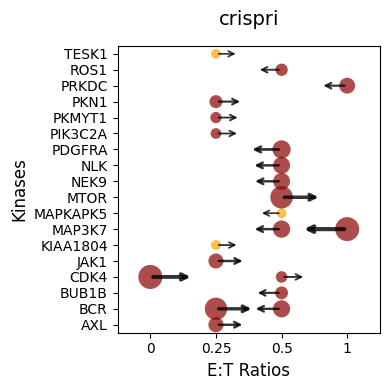

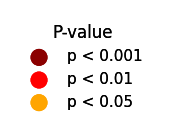


Bonferroni-Corrected Analysis Summary (Significant Samples Only):
Total samples analyzed: 39
Significant samples (α = 0.05): 21
Total valid p-values calculated: 39

Distance difference range: -0.1551 to -0.0162

Detailed Results (Significant Samples Only):
              sample    kinase own_dosage closest_dosage  distance_difference  \
0        1to0.25_AXL       AXL       0.25            0.5            -0.056371   
1        1to0.25_BCR       BCR       0.25              1            -0.110651   
2         1to0.5_BCR       BCR        0.5           0.25            -0.052855   
3       1to0.5_BUB1B     BUB1B        0.5           0.25            -0.041944   
6        1to0.5_CDK4      CDK4        0.5              1            -0.028185   
7     Untreated_CDK4      CDK4          0           0.25            -0.138463   
12      1to0.25_JAK1      JAK1       0.25            0.5            -0.058198   
13  1to0.25_KIAA1804  KIAA1804       0.25            0.5            -0.021541   
14     1to0.5

In [ ]:
# print legend seperately

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
import os

# Assuming you have results_df from the previous analysis
false_samples = results_df[results_df['closer_to_own_group'] == False]

# Function to calculate p-value for distance comparison using Mann-Whitney U test
def calculate_distance_pvalue_mannwhitney(sample_name, own_dosage, closest_dosage, dists_df):
    """
    Calculate p-value comparing distances to own group vs closest group
    using Mann-Whitney U test (non-parametric alternative to t-test)
    """
    # Get samples in own dosage group (excluding self)
    own_group_samples = dists_df[dists_df['dosage'] == own_dosage].index
    own_group_samples = [s for s in own_group_samples if s != sample_name]
    
    # Get samples in closest dosage group
    closest_group_samples = dists_df[dists_df['dosage'] == closest_dosage].index
    closest_group_samples = [s for s in closest_group_samples if s != sample_name]
    
    if len(own_group_samples) == 0 or len(closest_group_samples) == 0:
        return np.nan
    
    # Calculate distances to each group
    own_distances = [dists_df.loc[sample_name, target] for target in own_group_samples]
    closest_distances = [dists_df.loc[sample_name, target] for target in closest_group_samples]
    
    # Perform Mann-Whitney U test (non-parametric)
    try:
        statistic, p_value = stats.mannwhitneyu(own_distances, closest_distances, 
                                               alternative='two-sided')
        return p_value
    except:
        return np.nan

# Calculate p-values for false samples
enhanced_results = []
for _, row in false_samples.iterrows():
    sample_name = row['sample']
    own_dosage = row['own_dosage']
    
    # Find closest dosage group
    distances = {
        '0': row['dist_to_0'],
        '0.25': row['dist_to_0.25'], 
        '0.5': row['dist_to_0.5'],
        '1': row['dist_to_1']
    }
    
    valid_distances = {k: v for k, v in distances.items() if not pd.isna(v)}
    closest_dosage = min(valid_distances.keys(), key=lambda x: valid_distances[x])
    
    # Calculate p-value using Mann-Whitney U test
    p_value = calculate_distance_pvalue_mannwhitney(sample_name, own_dosage, closest_dosage, dists_df)
    
    enhanced_results.append({
        'sample': sample_name,
        'kinase': row['kinase'],
        'own_dosage': own_dosage,
        'closest_dosage': closest_dosage,
        'distance_difference': row['distance_difference'],
        'p_value_raw': p_value
    })

enhanced_df = pd.DataFrame(enhanced_results)

# Apply Bonferroni correction only
valid_pvalues = enhanced_df['p_value_raw'].dropna()
if len(valid_pvalues) > 0:
    # Apply Bonferroni correction
    rejected_bonf, pvals_corrected_bonf, _, _ = multipletests(valid_pvalues, method='bonferroni')
    
    # Add corrected p-values back to dataframe
    enhanced_df['p_value_bonferroni'] = np.nan
    enhanced_df['significant_bonferroni'] = False
    
    valid_indices = enhanced_df['p_value_raw'].notna()
    enhanced_df.loc[valid_indices, 'p_value_bonferroni'] = pvals_corrected_bonf
    enhanced_df.loc[valid_indices, 'significant_bonferroni'] = rejected_bonf
else:
    enhanced_df['p_value_bonferroni'] = np.nan
    enhanced_df['significant_bonferroni'] = False


# FILTER TO ONLY SIGNIFICANT SAMPLES
significant_df = enhanced_df[enhanced_df['significant_bonferroni'] == True]

if len(significant_df) == 0:
    print("No significant samples found at α = 0.05 (Bonferroni-corrected)")
    print(f"Total samples analyzed: {len(enhanced_df)}")
else:
    if pert_type == "crispra":
        fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    # Get unique kinases and set up positions
    kinases = significant_df['kinase'].unique()
    dosage_positions = {'0': 0, '0.25': 1, '0.5': 2, '1': 3}
    dosage_labels = ['0', '0.25', '0.5', '1']

    # Set up the plot
    ax.set_xlim(-0.5, 3.5)
    ax.set_ylim(-0.5, len(kinases) - 0.5)
    ax.set_yticks(range(len(kinases)))
    ax.set_yticklabels(kinases)
    ax.set_xticks(range(4))
    ax.set_xticklabels(dosage_labels)
    ax.grid(False)

    # Normalize distance differences for arrow lengths
    max_dist_diff = significant_df['distance_difference'].abs().max()

    # Handle p-values for dot sizes
    significant_df['neg_log_p'] = -np.log10(significant_df['p_value_bonferroni'].fillna(0.5))
    max_neg_log_p = significant_df['neg_log_p'].max()
    min_neg_log_p = significant_df['neg_log_p'].min()

    # Plot each sample
    for idx, (_, row) in enumerate(significant_df.iterrows()):
        kinase = row['kinase']
        own_dosage = row['own_dosage']
        closest_dosage = row['closest_dosage']
        dist_diff = abs(row['distance_difference'])
        p_value = row['p_value_bonferroni']
        neg_log_p = row['neg_log_p']
        
        # Get positions
        kinase_y = list(kinases).index(kinase)
        own_x = dosage_positions[own_dosage]
        closest_x = dosage_positions[closest_dosage]
        
        # Calculate dot size and color based on Bonferroni-corrected p-value
        if not np.isnan(p_value):
            dot_size = 50 + (neg_log_p - min_neg_log_p) / (max_neg_log_p - min_neg_log_p) * 250
            # Color based on Bonferroni-corrected significance
            if p_value < 0.001:
                dot_color = 'darkred'
            elif p_value < 0.01:
                dot_color = 'red'
            elif p_value < 0.05:
                dot_color = 'orange'
            else:
                dot_color = 'lightcoral'
        else:
            dot_size = 100
            dot_color = 'gray'
        
        # Plot the sample's own dosage position
        ax.scatter(own_x, kinase_y, c=dot_color, s=dot_size, marker='o', 
                  alpha=0.7,  edgecolors='none')
        
        # Draw arrow
        if own_x != closest_x and not np.isnan(dist_diff):
            arrow_length_factor = 0.3 + (dist_diff / max_dist_diff) * 0.4
            direction = 1 if closest_x > own_x else -1
            arrow_end_x = own_x + direction * arrow_length_factor
            
            if direction > 0:
                arrow_end_x = min(arrow_end_x, closest_x)
            else:
                arrow_end_x = max(arrow_end_x, closest_x)
            
            arrow_width = 1 + (dist_diff / max_dist_diff) * 2
            
            ax.annotate('', xy=(arrow_end_x, kinase_y), xytext=(own_x, kinase_y),
                       arrowprops=dict(arrowstyle='->', color='black', 
                                     lw=arrow_width, alpha=0.8))

    # Customize the plot
    ax.set_xlabel('E:T Ratios', fontsize=12)
    ax.set_ylabel('Kinases', fontsize=12)
    title = pert_type if 'pert_type' in locals() else 'Dosage Response Analysis'
    ax.set_title(f'{title}', fontsize=14, pad=15)

    plt.tight_layout()

    # Save the main figure
    if 'figure_dir' in locals():
        plt.savefig(os.path.join(figure_dir, "bonferroni_dosage_analysis_significant.svg"), 
                    dpi=300, bbox_inches='tight')
        plt.savefig(os.path.join(figure_dir, "bonferroni_dosage_analysis_significant.png"), 
                    dpi=300, bbox_inches='tight')
        plt.savefig(os.path.join(figure_dir, "bonferroni_dosage_analysis_significant.pdf"), 
                    dpi=300, bbox_inches='tight')

    plt.show()

    # Create separate legend figure
    fig_legend, ax_legend = plt.subplots(figsize=(2, 1.5))
    ax_legend.axis('off')

    # Create legend elements for p-value colors
    legend_elements = [
        plt.scatter([], [], c='darkred', s=150, label='p < 0.001', edgecolors='none'),
        plt.scatter([], [], c='red', s=150, label='p < 0.01', edgecolors='none'),
        plt.scatter([], [], c='orange', s=150, label='p < 0.05', edgecolors='none'),
    ]

    # # Create legend elements for dot size (representing -log10(p-value) and distance difference)
    # size_legend_elements = [
    #     plt.scatter([], [], c='gray', s=50, label='Small effect', edgecolors='none'),
    #     plt.scatter([], [], c='gray', s=150, label='Medium effect', edgecolors='none'),
    #     plt.scatter([], [], c='gray', s=300, label='Large effect', edgecolors='none'),
    # ]

    # # Create legend elements for arrows
    # arrow_legend_elements = [
    #     plt.Line2D([0], [0], color='black', lw=1, label='Small distance difference'),
    #     plt.Line2D([0], [0], color='black', lw=2, label='Medium distance difference'),
    #     plt.Line2D([0], [0], color='black', lw=3, label='Large distance difference'),
    # ]

    # Add legends
    legend1 = ax_legend.legend(handles=legend_elements, title='P-value', 
                               loc='upper left', frameon=False, fontsize=11, title_fontsize=12)
    ax_legend.add_artist(legend1)

    # legend2 = ax_legend.legend(handles=size_legend_elements, title='Effect Size (Dot Size)', 
    #                            loc='upper left', bbox_to_anchor=(0, 0.6), 
    #                            frameon=False, fontsize=11, title_fontsize=12)
    # ax_legend.add_artist(legend2)

    # ax_legend.legend(handles=arrow_legend_elements, title='Distance Difference (Arrow Width)', 
    #                  loc='upper left', bbox_to_anchor=(0, 0.2), 
    #                  frameon=False, fontsize=11, title_fontsize=12)

    plt.tight_layout()

    # Save the legend figure
    if 'figure_dir' in locals():
        fig_legend.savefig(os.path.join(figure_dir, "bonferroni_legend.svg"), 
                          dpi=300, bbox_inches='tight')
        fig_legend.savefig(os.path.join(figure_dir, "bonferroni_legend.png"), 
                          dpi=300, bbox_inches='tight')
        fig_legend.savefig(os.path.join(figure_dir, "bonferroni_legend.pdf"), 
                          dpi=300, bbox_inches='tight')

    plt.show()

    # Print Bonferroni-specific summary statistics
    print("\nBonferroni-Corrected Analysis Summary (Significant Samples Only):")
    print("="*60)
    print(f"Total samples analyzed: {len(enhanced_df)}")
    print(f"Significant samples (α = 0.05): {len(significant_df)}")
    print(f"Total valid p-values calculated: {enhanced_df['p_value_raw'].notna().sum()}")

    print(f"\nDistance difference range: {significant_df['distance_difference'].min():.4f} to {significant_df['distance_difference'].max():.4f}")

    # Display the results with Bonferroni focus
    print("\nDetailed Results (Significant Samples Only):")
    display_cols = ['sample', 'kinase', 'own_dosage', 'closest_dosage', 'distance_difference', 
                   'p_value_raw', 'p_value_bonferroni', 'significant_bonferroni']
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    print(significant_df[display_cols].round(6))